In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('paper')
sns.set(font_scale=1.5)

In [3]:
records = np.load('/artemis/readout/archive/2016-12-12-stanford-almn-res2-temp-sweep.npz')['records']

In [4]:
records.shape

(61,)

In [6]:
records.dtype.fields.keys()

['res_f_min_error',
 'res_Q_e_real',
 'res_frequency_data',
 'res_Q_error',
 'sweep.root_path',
 'number',
 'res_delay_error',
 'sweep.node_path',
 'res_model_s21',
 'res_f_0_error',
 'start_epoch',
 'roach_modulation_output',
 'stream.root_path',
 'res_f_min',
 'res_A_slope',
 'index',
 'S_xx',
 'S_xy',
 'res_phi_error',
 'roach_heterodyne',
 'roach_num_tone_samples',
 'res_Q_e_real_error',
 'res_f_0',
 'roach_hardware_delay_samples',
 'res_model_s21_at_f_0',
 'res_model_frequency',
 'res_redchi',
 'roach_adc_sample_rate',
 'res_A_slope_error',
 'res_Q_i',
 'res_A_mag',
 'res_Q_e',
 'roach_reference_sequence_number',
 'res_model_s21_normalized',
 'package_temperature',
 'res_Q_e_imag_error',
 'roach_debug_register',
 'roach_lo_frequency',
 'analysis_epoch',
 'S_frequency',
 'res_delay',
 'roach_num_tones',
 'stream.node_path',
 'io_class',
 'res_s21_data_normalized',
 'res_A_mag_error',
 'S_yy',
 'res_phi',
 'res_model_s21_normalized_at_f_0',
 'roach_loopback',
 'roach_fft_shift_regis

In [393]:
Q = records['res_Q']
Q_err = records['res_Q_error']
iQ = 1/Q
iQi = 1/records['res_Q_i']
iQerr = Q_err/Q**2
tt = records['package_temperature']
f_0 = records['res_f_0']
f_0_err = records['res_f_0_error']
x = 1-f_0/f_0.max()
x_err = f_0_err/f_0.max()

In [11]:
import lmfit

In [140]:
from scipy.constants import c, h, k as k_B, pi
from scipy.special import i0,k0,psi
N0 = 1.72e10

def qiqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return (pi*np.exp(delta/(k_B*T))/
           (4*alpha_k*np.sinh(h*f/(2*k_B*T))*
           k0(h*f/(2*k_B*T))))
def iqitls(T,f=150e6):
    return np.tanh(h * f / (2 * k_B * T))

def iqi(T,alpha_k=1,Tc=.73,f=150e6,L0=0,tls_factor=0):
    return (1/qiqp(T,alpha_k,Tc,f)) + iqitls(T,f)*tls_factor + L0

def xqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return ((alpha_k/(2*delta))*
           (1+(np.sqrt(2*delta/(pi*k_B*T))*
              np.exp(-h*f/(2*k_B*T))*
              i0(h*f/(2*k_B*T))))*
            np.sqrt(2*pi*k_B*T*delta)*np.exp(-delta/(k_B*T)))
def xtls(T,f=150e6):
    return pi * (psi(0.5 + h * f / (2j * pi * k_B * T)).real - np.log(h * f / (k_B * T)))

def xtotal(T,alpha_k=1,Tc=.73,f=150e6,x0=0,tls_factor=0):
    return xqp(T,alpha_k,Tc,f) - tls_factor*xtls(T,f) + x0

In [19]:
T = np.linspace(50e-3,250e-3,100)

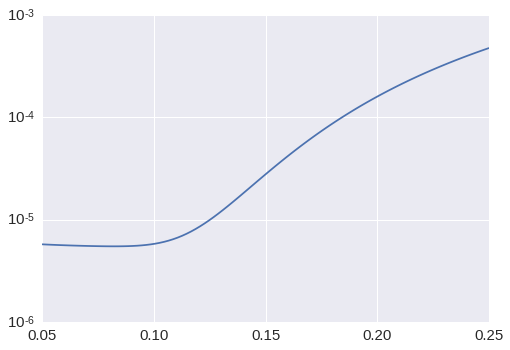

In [31]:
semilogy(T,iqi(T,tls_factor=1e-5,L0=5e-6))

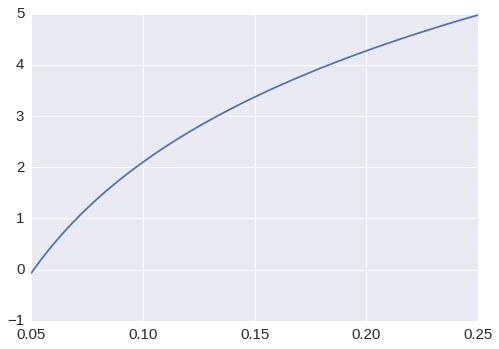

In [139]:
plot(T,xtls(T))

In [142]:
iqi_model = lmfit.Model(iqi,independent_vars=['T'])
x_model = lmfit.Model(xtotal,independent_vars=['T'])

In [143]:
def iqiguess(self,**kwargs):
    p = lmfit.Parameters()
    p.add(name='alpha_k',value=.25,min=0,max=1)
    p.add(name='Tc',value=0.73,min=.5,max=1)
    p.add(name='L0',value=0,min=0,max=1e-3)
    p.add(name='tls_factor',value=0,min=0,max=1e-3)
    p.add(name='f',value=150e6,vary=False)
    return p
iqi_model.guess = iqiguess

def xguess(self,**kwargs):
    p = lmfit.Parameters()
    p.add(name='alpha_k',value=.25,min=0,max=1)
    p.add(name='Tc',value=0.73,min=.5,max=1)
    p.add(name='x0',value=0,min=0,max=1e-3)
    p.add(name='tls_factor',value=0,min=0,max=1e-3)
    p.add(name='f',value=150e6,vary=False)
    return p
x_model.guess = xguess

In [127]:
lmfit.ui.ipy_fitter??

In [430]:
qftr = lmfit.ui.Fitter(iQi,T=tt,model=iqi_model,weights=1/iQerr)

In [431]:
qftr.fit()
qftr.fit()
qftr.fit()

In [432]:
qftr.current_params

Parameters([('Tc', <Parameter 'Tc', 0.68577625475600834, bounds=[0.5:1]>),
            ('alpha_k',
             <Parameter 'alpha_k', 0.098994006408152146, bounds=[0:1]>),
            ('tls_factor',
             <Parameter 'tls_factor', 1.7381841797822206e-06, bounds=[0:0.001]>),
            ('L0', <Parameter 'L0', 5.1753043511386098e-06, bounds=[0:0.001]>),
            ('f',
             <Parameter 'f', value=150000000.0 (fixed), bounds=[-inf:inf]>)])

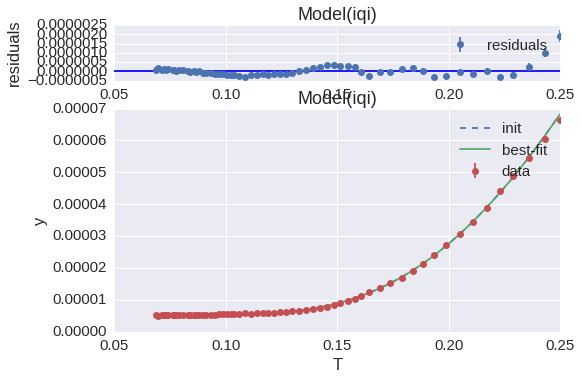

In [433]:
blah=qftr.current_result.plot()
#yscale('log')

In [434]:
print ftr.current_result.fit_report()

[[Model]]
    Model(xtotal)
[[Fit Statistics]]
    # function evals   = 13
    # data points      = 56
    # variables        = 4
    chi-square         = 43.783
    reduced chi-square = 0.842
    Akaike info crit   = -1.632
    Bayesian info crit = 6.469
[[Variables]]
    Tc:           0.68146884 +/- 0.005727 (0.84%) (init= 0.6814688)
    x0:           2.6952e-06 +/- 2.53e-06 (93.74%) (init= 2.695188e-06)
    tls_factor:   1.4533e-08 +/- 1.27e-06 (8706.38%) (init= 3.946608e-13)
    alpha_k:      0.14895250 +/- 0.007028 (4.72%) (init= 0.1489525)
    f:            1.5e+08 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(Tc, alpha_k)               =  0.996 
    C(x0, tls_factor)            =  0.952 
    C(Tc, tls_factor)            = -0.803 
    C(tls_factor, alpha_k)       = -0.761 
    C(Tc, x0)                    = -0.662 
    C(x0, alpha_k)               = -0.622 



In [435]:
qres=qftr.current_result.emcee(burn=500)

In [70]:
import corner

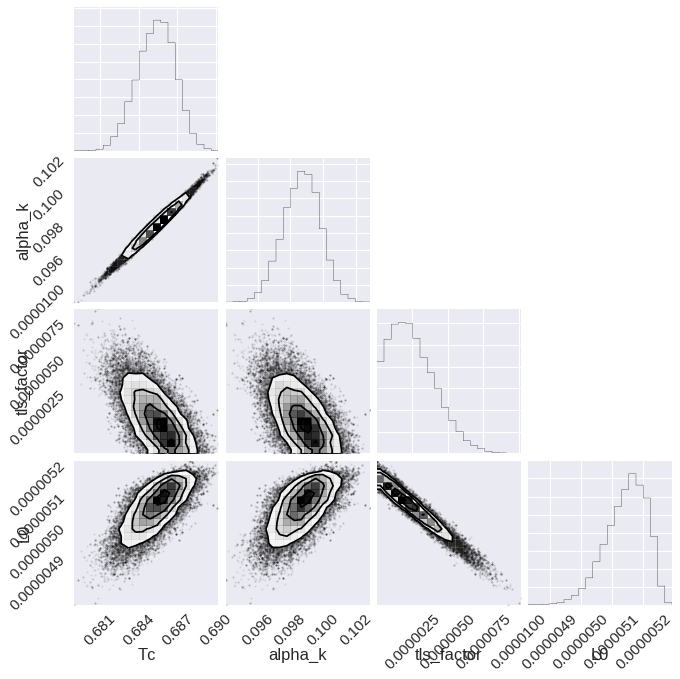

In [436]:
_=corner.corner(qres.flatchain)

In [448]:
xftr = lmfit.ui.Fitter(x[:-5],T=tt[:-5],model=x_model,weights=1e-2/x_err[:-5])

In [449]:
xftr.fit()
xftr.fit()
xftr.fit()
xftr.fit()
xftr.fit()

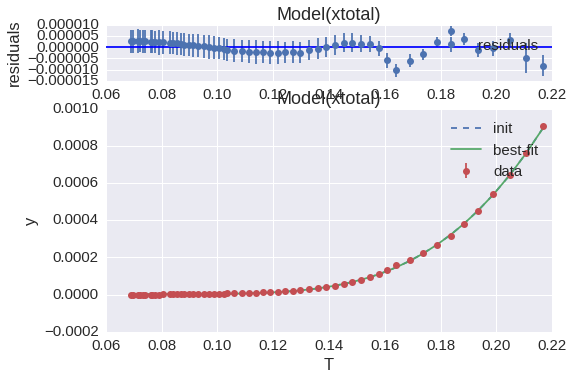

In [450]:
_=xftr.current_result.plot()

In [451]:
print xftr.current_result.fit_report()

[[Model]]
    Model(xtotal)
[[Fit Statistics]]
    # function evals   = 13
    # data points      = 56
    # variables        = 4
    chi-square         = 43.783
    reduced chi-square = 0.842
    Akaike info crit   = -1.632
    Bayesian info crit = 6.469
[[Variables]]
    Tc:           0.68146884 +/- 0.005727 (0.84%) (init= 0.6814688)
    x0:           2.6952e-06 +/- 2.53e-06 (93.74%) (init= 2.695188e-06)
    tls_factor:   1.4533e-08 +/- 1.27e-06 (8706.38%) (init= 3.946608e-13)
    alpha_k:      0.14895250 +/- 0.007028 (4.72%) (init= 0.1489525)
    f:            1.5e+08 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(Tc, alpha_k)               =  0.996 
    C(x0, tls_factor)            =  0.952 
    C(Tc, tls_factor)            = -0.803 
    C(tls_factor, alpha_k)       = -0.761 
    C(Tc, x0)                    = -0.662 
    C(x0, alpha_k)               = -0.622 



In [452]:
xres=xftr.current_result.emcee(burn=500)

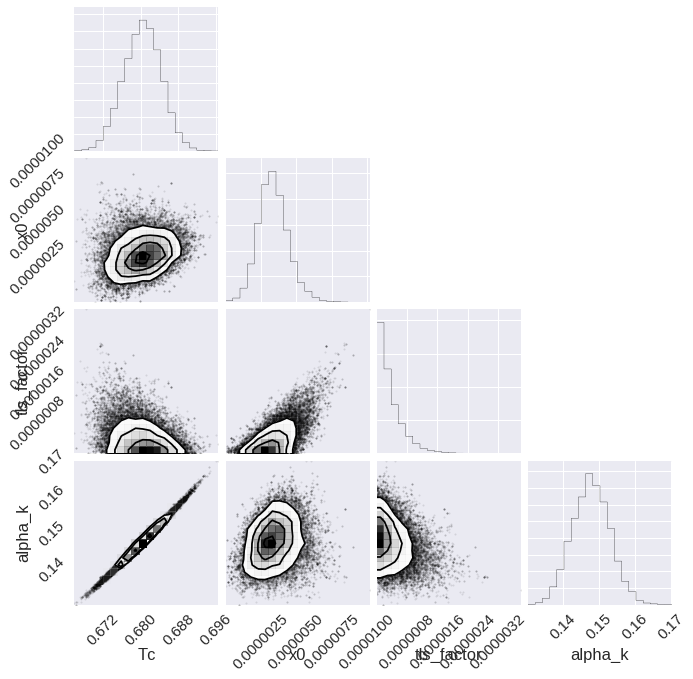

In [453]:
_=corner.corner(xres.flatchain)

In [384]:
def global_lnlike(params,T_data,iqi_data,iqi_error,x_data,x_error):
    prior = global_lnprior(params)
    if prior == -np.inf:
        return -np.inf
    Tc,alpha_x,alpha_q,logtls_x,logtls_q,x0,iqi0,efacx = params
    efacq = 1
    #print params
    iqi_predict = iqi(T_data,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**(logtls_q))
    x_predict = xtotal(T_data,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**(logtls_x))
    inv_sigma2_q = 1/(iqi_error*efacq)**2
    inv_sigma2_x = 1/(x_error*efacx)**2
    iqi_deviates = (iqi_predict - iqi_data)**2 * inv_sigma2_q
    x_deviates = (x_predict-x_data)**2 * inv_sigma2_x
    return prior - ((iqi_deviates - np.log(inv_sigma2_q)).sum()
              + (x_deviates - np.log(inv_sigma2_x)).sum())

def global_lnprior(params):
    Tc,alpha_x,alpha_q,logtls_x,logtls_q,x0,iqi0,efacx = params
    if 0.4 > Tc or Tc > 1.0:
        return -np.inf
    if 0 > alpha_x or alpha_x > 1.0:
        return -np.inf
    if 0 > alpha_q or alpha_q > 1.0:
        return -np.inf
    if logtls_x > 0 or logtls_x < -8:
        return -np.inf
    if logtls_q > 0 or logtls_q < -8:
        return -np.inf
    if -1e-4 > x0 or x0 > 1e-4:
        return -np.inf
    if 0 > iqi0 or iqi0 > 1e-3:
        return -np.inf
    if efacx < 1 or efacx > 1e3:
        return -np.inf
#    if efacq < 1 or efacq > 1e4:
#        return -np.inf
    return -((Tc-.73)/0.01)**2


In [216]:
-np.inf == -np.inf

True

In [187]:
import emcee

In [394]:
samp = emcee.EnsembleSampler(64,8,global_lnlike,args=(tt[:-3],iQi[:-3],iQerr[:-3],x[:-3],x_err[:-3]))

In [403]:
p0 = np.array([.65,.15,.09,-8,-8,0,0,200])[None,:] + np.random.rand(64,8)*np.array([.1,.1,.1,2,2,1e-5,1e-4,1000])

In [409]:
p0 = samp.flatchain.mean(0)[None,:] + 1e-3*np.random.rand(64,8)*np.array([.1,.1,.1,2,2,1e-5,1e-4,1000])

In [408]:
samp.flatchain.shape

(640000, 8)

In [357]:
samp.chain.shape

(64, 0, 8)

In [410]:
#p0 = np.median(samp.chain[:,:,:],axis=1)
samp.reset()
samp.run_mcmc(p0,2000)
p0 = np.median(samp.chain[:,-1000:,:],axis=1)
samp.reset()
samp.run_mcmc(p0,5000)

(array([[  6.92317721e-01,   1.64667600e-01,   1.04792794e-01,
          -7.86231976e+00,  -7.32362201e+00,   3.40660683e-06,
           5.26716279e-06,   1.46062294e+02],
        [  6.94186098e-01,   1.68556778e-01,   1.06493237e-01,
          -7.35849611e+00,  -7.83658898e+00,   2.83790406e-06,
           5.28765265e-06,   1.32217102e+02],
        [  6.93806292e-01,   1.67921680e-01,   1.06177658e-01,
          -6.90058056e+00,  -7.87035290e+00,   2.69452073e-06,
           5.27625772e-06,   1.32271640e+02],
        [  6.94799624e-01,   1.68776643e-01,   1.07060753e-01,
          -7.48554337e+00,  -7.02079381e+00,   5.01544799e-06,
           5.28650466e-06,   1.17955230e+02],
        [  6.93367991e-01,   1.66857572e-01,   1.05764920e-01,
          -7.33241263e+00,  -5.98525899e+00,   4.53637840e-06,
           5.24238097e-06,   1.45962039e+02],
        [  6.94349222e-01,   1.69078983e-01,   1.06766869e-01,
          -7.15094086e+00,  -6.26053791e+00,   3.55016783e-06,
           5.2

In [411]:
p0 = np.median(samp.chain[:,:,:],axis=1)
samp.reset()
samp.run_mcmc(p0,10000)

(array([[  6.93071843e-01,   1.66990650e-01,   1.05527484e-01,
          -6.67662637e+00,  -7.12591606e+00,   2.84093691e-06,
           5.26563793e-06,   1.32704716e+02],
        [  6.94142727e-01,   1.68449719e-01,   1.06544070e-01,
          -6.69066390e+00,  -6.10038429e+00,   3.92567750e-06,
           5.24417099e-06,   1.13078680e+02],
        [  6.92980295e-01,   1.65554599e-01,   1.05267120e-01,
          -7.63396930e+00,  -7.77769877e+00,   4.16276077e-06,
           5.27196749e-06,   1.26714616e+02],
        [  6.93653210e-01,   1.67785338e-01,   1.06114553e-01,
          -6.56797526e+00,  -6.12008984e+00,   3.54848662e-06,
           5.23340343e-06,   1.28824448e+02],
        [  6.96746331e-01,   1.72026084e-01,   1.08815214e-01,
          -7.80073012e+00,  -6.78624075e+00,   3.79499711e-06,
           5.29352375e-06,   1.27744687e+02],
        [  6.94798406e-01,   1.69169694e-01,   1.07059827e-01,
          -6.92889980e+00,  -7.46833596e+00,   4.29763039e-06,
           5.2

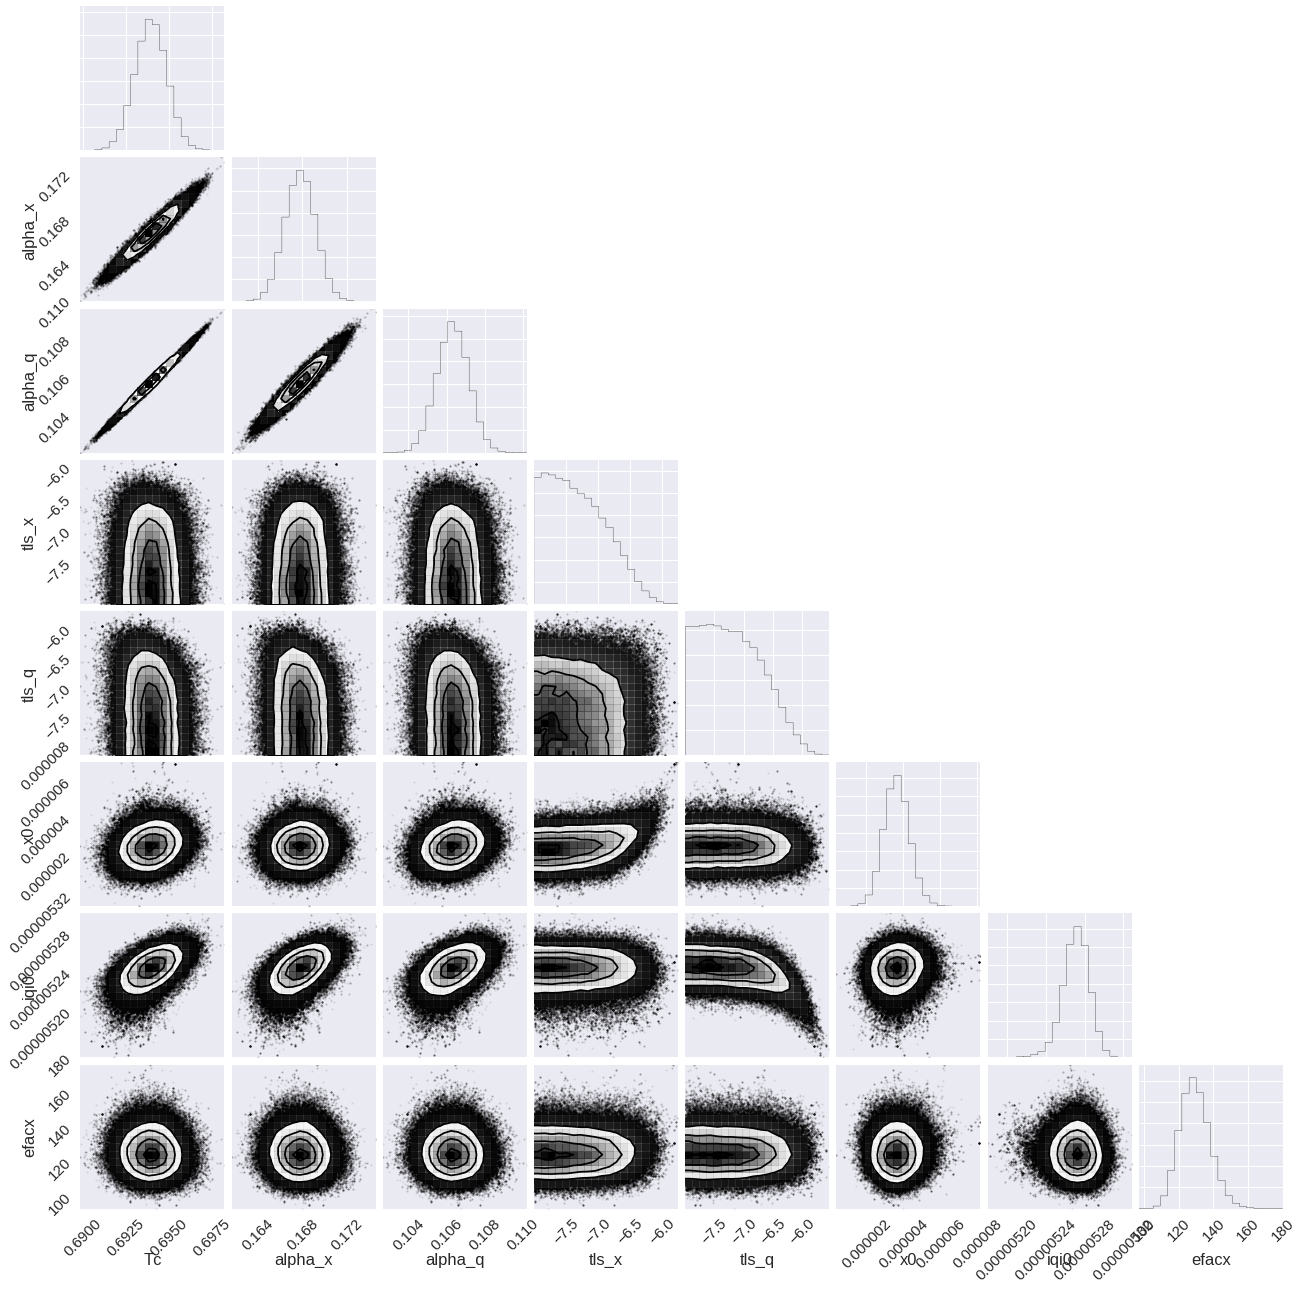

In [412]:
_ = corner.corner(samp.flatchain,labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx'])

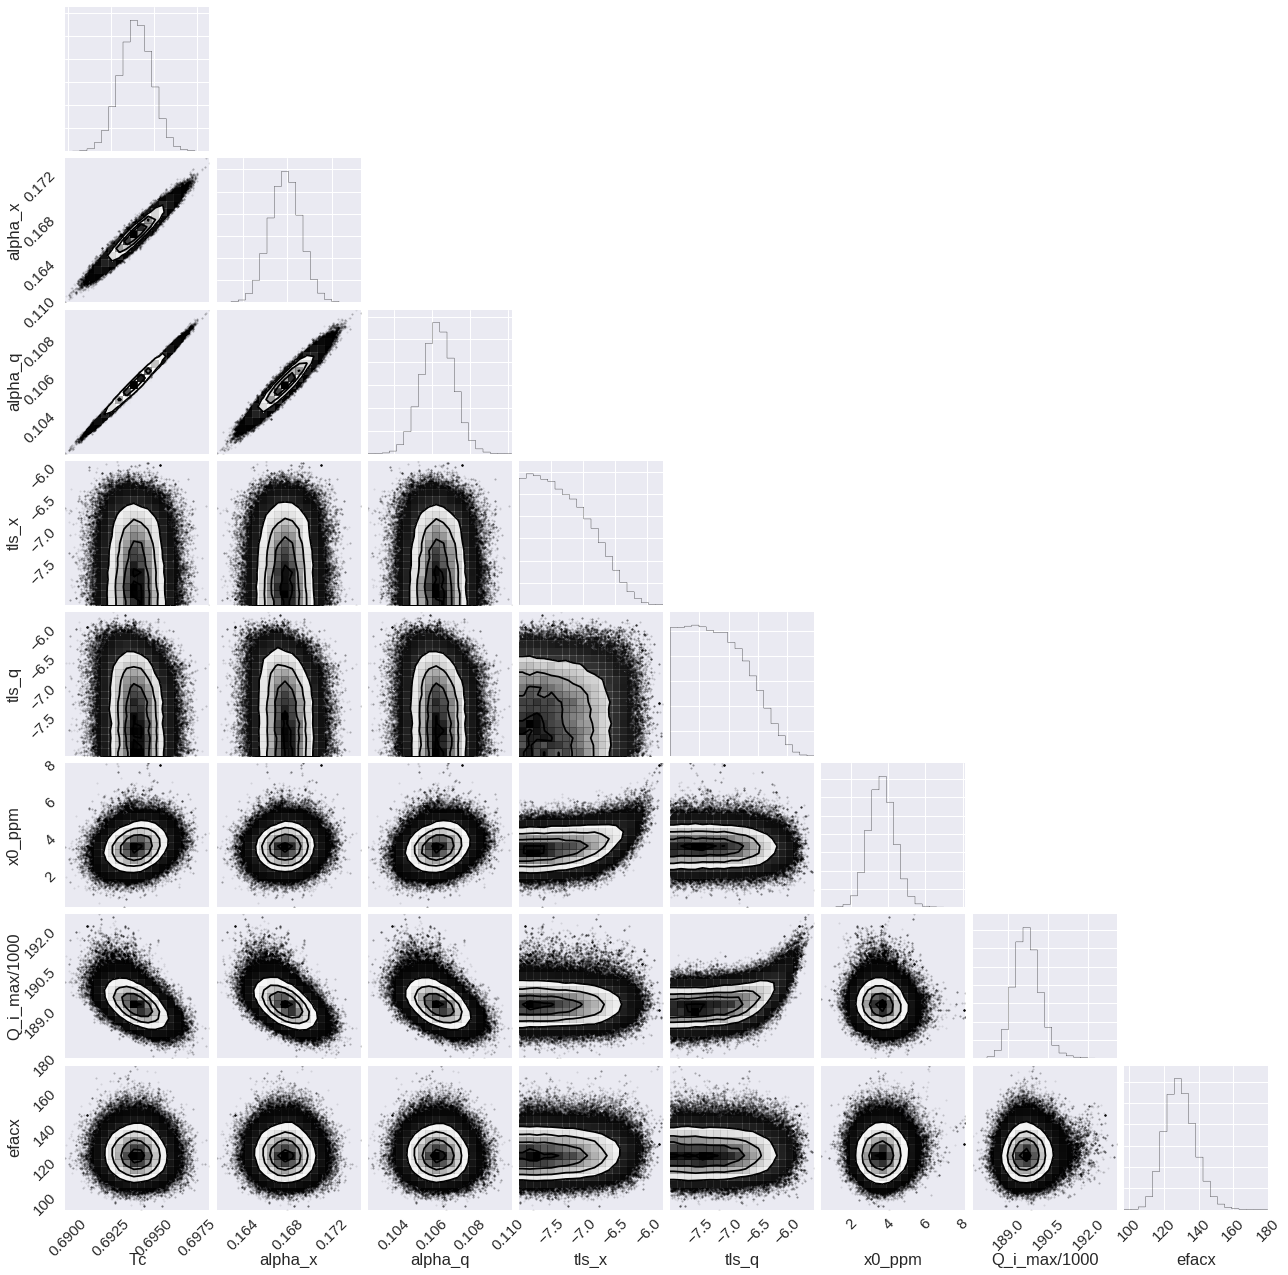

In [461]:
transformed_chain = samp.flatchain.copy()
transformed_chain[:,5] = transformed_chain[:,5]*1e6
transformed_chain[:,6] = 1e-3/(transformed_chain[:,6])
_ = corner.corner(transformed_chain,labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0_ppm','Q_i_max/1000','efacx'])
savefig('/home/gjones/paper_plots/iqi_x_joint_MBTLS_corner.pdf',bbox_inches='tight')

In [380]:
10**-6.5

3.162277660168379e-07

In [475]:
samp.flatchain.mean(0)

array([  6.93970797e-01,   1.67801062e-01,   1.06318252e-01,
        -7.31699556e+00,  -7.19529211e+00,   3.65098640e-06,
         5.27108976e-06,   1.29435595e+02])

In [477]:
10**-6.5

3.162277660168379e-07

In [476]:
samp.flatchain.std(0)

array([  9.25599231e-04,   1.38637082e-03,   8.38290887e-04,
         4.45523891e-01,   5.05300895e-01,   6.95674809e-07,
         1.38241718e-08,   8.72543692e+00])

In [415]:
1/samp.flatchain.mean(0)[6]

189714.09068757397

In [308]:
samp.flatchain.shape

(640000, 8)

In [ ]:
#(tt,iQ,iQerr,x,x_err)

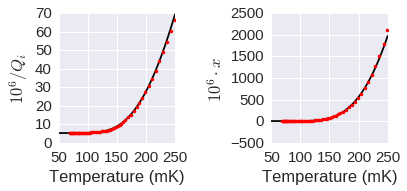

In [474]:
def eval_params(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
nominal = samp.flatchain.mean(0)
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
#efacx=200
fig,axs=subplots(1,2,figsize=(6,3))
ax1,ax2= axs.flatten()
iqip,xp = eval_params(nominal,T)
ax1.plot(T*1000,1e6*iqip,color='k')
ax2.plot(T*1000,1e6*xp,color='k')

ax1.errorbar(tt*1000,1e6*iQi,yerr=1e6*iQerr,color='r',linestyle='',marker='.')
ax2.errorbar(tt*1000,1e6*x,yerr=1e6*x_err*efacx,linestyle='',color='r',marker='.')
ax2.errorbar(tt*1000,1e6*x,yerr=1e6*x_err,linestyle='')

ax1.set_xlabel('Temperature (mK)')
ax2.set_xlabel('Temperature (mK)')
ax1.set_ylabel('$10^6/Q_i$')
ax2.set_ylabel('$10^6\cdot x$')
fig.tight_layout()
fig.savefig('/home/gjones/paper_plots/iqi_x_MBTLS_simple_linear.pdf',bbox_inches='tight')
#ax1.set_yscale('log')
#ax2.set_yscale('log')

#iqi_nom,x_nom = eval_params(nominal,tt)
#ax3.errorbar(tt,iQi-iqi_nom,yerr=iQerr,linestyle='')
#ax4.errorbar(tt,x-x_nom,yerr=x_err*efacx,linestyle='')

In [478]:
nominal

array([  6.93970797e-01,   1.67801062e-01,   1.06318252e-01,
        -7.31699556e+00,  -7.19529211e+00,   3.65098640e-06,
         5.27108976e-06,   1.29435595e+02])

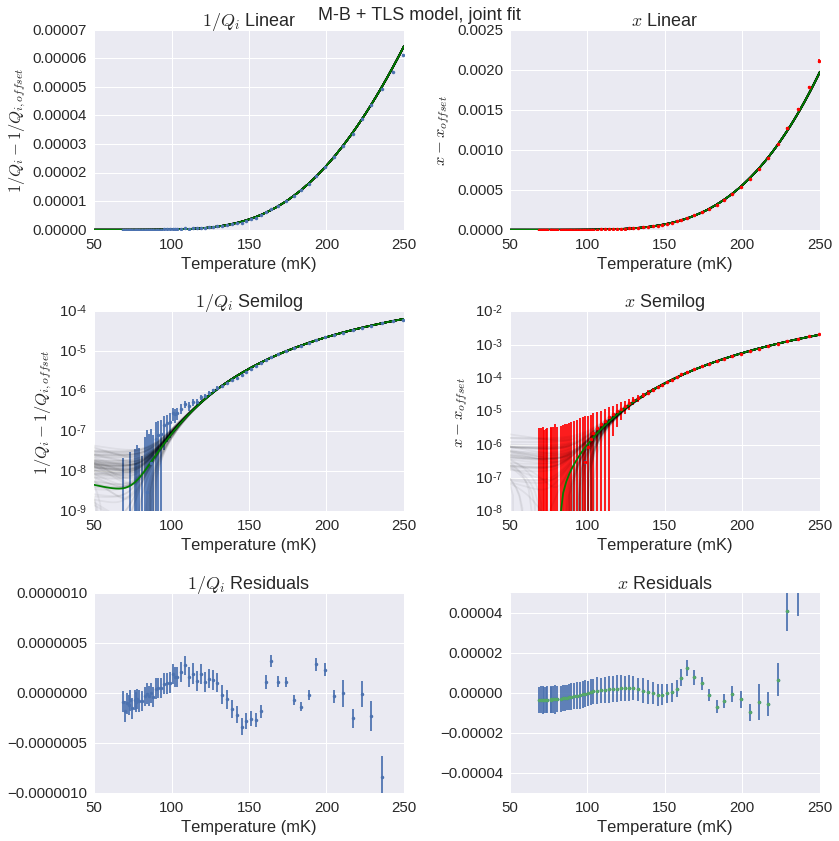

In [462]:
def eval_params(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
nominal = samp.flatchain.mean(0)
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
offset_q = iqi0
offset_x = x0
#efacx=200
fig,axs=subplots(3,2,figsize=(12,12))
ax1a,ax2a,ax1b,ax2b,ax3,ax4 = axs.flatten()
for ax1,ax2 in [(ax1a,ax2a),(ax1b,ax2b)]:
    for k in range(100):
        params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
        iqip,xp = eval_params(params,T)
        ax1.plot(T*1000,iqip-offset_q,alpha=.05,color='k')
        ax2.plot(T*1000,xp-offset_x,alpha=.05,color='k')
    iqip,xp = eval_params(nominal,T)
    ax1.plot(T*1000,iqip-offset_q,color='g')
    ax2.plot(T*1000,xp-offset_x,color='g')

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='')
    ax1.set_ylabel('$1/Q_i-1/Q_{i,offset}$')
    ax2.set_ylabel('$x-x_{offset}$')
ax1b.set_yscale('log')
ax2b.set_yscale('log')
ax1b.set_ylim(1e-9,1e-4)
ax2b.set_ylim(1e-8,1e-2)
ax1a.set_ylim(1e-9,7e-5)
ax2a.set_ylim(1e-8,2.5e-3)

iqi_nom,x_nom = eval_params(nominal,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.')
ax3.set_ylim(-1e-6,1e-6)
ax4.set_ylim(-5e-5,5e-5)
for ax in axs.flatten():
#    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
ax1a.set_title('$1/Q_i$ Linear')
ax2a.set_title('$x$ Linear')
ax1b.set_title('$1/Q_i$ Semilog')
ax2b.set_title('$x$ Semilog')
ax3.set_title('$1/Q_i$ Residuals')
ax4.set_title('$x$ Residuals')
fig.suptitle('M-B + TLS model, joint fit')
fig.tight_layout()
fig.savefig('/home/gjones/paper_plots/iqi_x_MBTLS_model_joint_fit_summary.pdf',bbox_inches='tight')


(-5e-05, 5e-05)

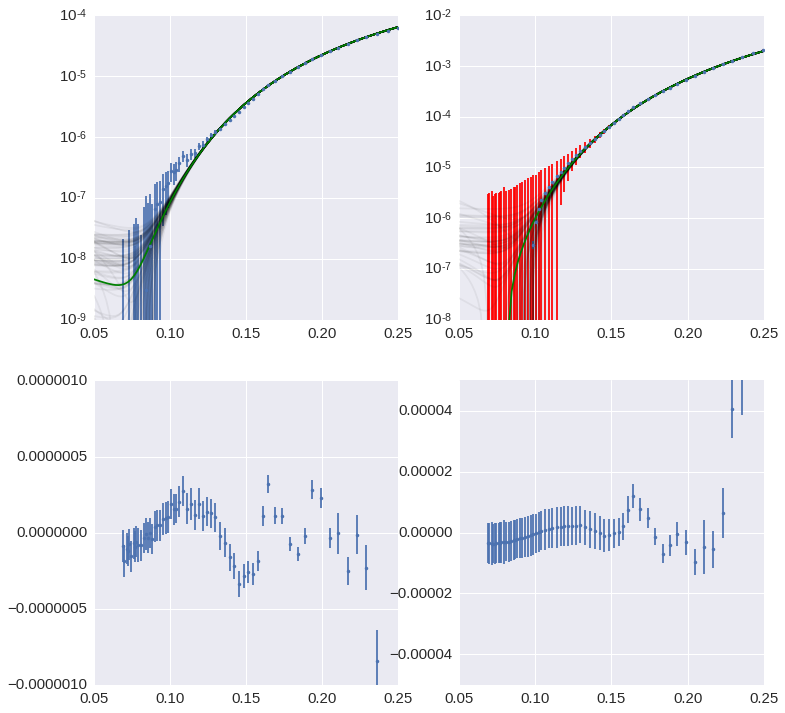

In [422]:
def eval_params(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
nominal = samp.flatchain.mean(0)
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
#efacx=200
fig,axs=subplots(2,2,figsize=(12,12))
ax1,ax2,ax3,ax4 = axs.flatten()
for k in range(100):
    params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
    iqip,xp = eval_params(params,T)
    ax1.plot(T,iqip-iqi0,alpha=.05,color='k')
    ax2.plot(T,xp-x0,alpha=.05,color='k')
iqip,xp = eval_params(nominal,T)
ax1.plot(T,iqip-iqi0,color='g')
ax2.plot(T,xp-x0,color='g')

ax1.errorbar(tt,iQi-iqi0,yerr=iQerr,linestyle='',marker='.')
ax2.errorbar(tt,x-x0,yerr=x_err*efacx,linestyle='',color='r')
ax2.errorbar(tt,x-x0,yerr=x_err,linestyle='',marker='.')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim(1e-9,1e-4)
ax2.set_ylim(1e-8,1e-2)

iqi_nom,x_nom = eval_params(nominal,tt)
ax3.errorbar(tt,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.')
ax4.errorbar(tt,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.')
ax3.set_ylim(-1e-6,1e-6)
ax4.set_ylim(-5e-5,5e-5)

In [362]:
nominal

array([  6.90132082e-01,   1.63444202e-01,   1.01395935e-01,
        -8.77251785e+00,  -1.76757448e+65,   2.70560349e-06,
         1.13620863e-05,   1.85683498e+02])

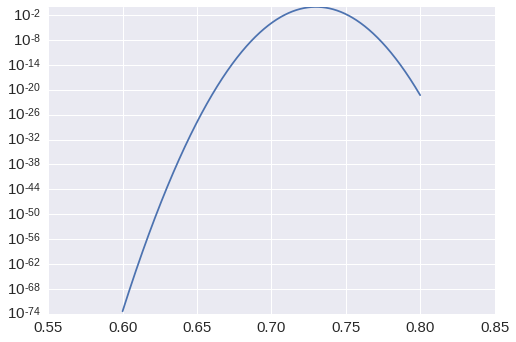

In [383]:
T2 = np.linspace(0.6,0.8,1000)
semilogy(T2,np.exp(-((T2-.73)/0.01)**2))